<a href="https://colab.research.google.com/github/eduardodut/Analise-tweets-ICD-Unifor/blob/master/AnaliseTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carregamento e leitura dos dados a partir do repositório localizado em https://github.com/eduardodut/Analise-tweets-ICD-Unifor

In [2]:
import pandas as pd
import pickle
#função que realiza o download dos arquivos json
def carregarDados():
  import json
  import pandas as pd

  #download dos arquivos localizados no reposítório do projeto
  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/LulaOficial.json


  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/jairbolsonaro.json     

  #transformação dos arquivos json em datasets
  dataset_lula = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/LulaOficial.json') as lula_file:
    dados = json.load(lula_file)
    dataset_lula = pd.DataFrame(dados)


  dataset_bolso = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/jairbolsonaro.json') as bolso_file:
    dados = json.load(bolso_file)
    dataset_bolso = pd.DataFrame(dados)

  return dataset_bolso, dataset_lula

#utilização da função definida acima
dataset_bolso, dataset_lula = carregarDados()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.6M  100 47.6M    0     0  11.5M      0  0:00:04  0:00:04 --:--:-- 11.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.9M  100 25.9M    0     0  12.2M      0  0:00:02  0:00:02 --:--:-- 12.2M


1ª Etapa de limpeza de dados:

*   Foco nas características quantitativas
*   Criação de novas features a partir das informações do dataset
*   Exclusão de features desnecessárias ou sem utilidade para a análise



In [0]:
import numpy as np

def cleaning_data(dataset):

  #realiza cópia do dataset
  dataset_temp = dataset.copy()
  
  #conversão da coluna 'created_at' para formato de data
  dataset_temp['created_at'] = dataset_temp['created_at'].astype('datetime64[ns]')
  # dataset_temp['created_at'] = pd.to_datetime(dataset_temp['created_at'])
  #criação da coluna 'caracter_count' a partir da coluna 'display_text_range', que indica o tamanho do tweet
  dataset_temp['character_count'] = [(dataset_temp['display_text_range'][i][1]-dataset_temp['display_text_range'][i][0] + 1)for i in range(0,dataset_temp.shape[0])]

  #função que extrai dados do dicionário da coluna 'user' e transforma em uma coluna do dataset
  def extracao_dados_user(coluna):
    if coluna not in dataset_temp.columns:
      dataset_temp[coluna] = [pd.DataFrame(dataset_temp['user']).loc[i][0].get(coluna) for i in range(0,dataset_temp.shape[0])]

  #função que extrai as hashtags e @ da coluna entities e as coloca em sua própria cluna, em forma de lista
  def extracao_entities():
         
    coluna_hashtags = []
    coluna_user_mentions = []

    for i in range(0,dataset_temp.shape[0]):
      list_hashtags = []
      list_user_mention = []
      if dataset_temp.loc[i]['entities'].get("hashtags") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("hashtags"))):
          list_hashtags.append(dataset_temp.loc[i]['entities'].get("hashtags")[j].get('text'))
      coluna_hashtags.append(list_hashtags)

      if dataset_temp.loc[i]['entities'].get("user_mentions") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("user_mentions"))):
         list_user_mention.append(dataset_temp.loc[i]['entities'].get("user_mentions")[j].get('name'))
      coluna_user_mentions.append(list_user_mention)

    dataset_temp['hashtags'] = coluna_hashtags
    dataset_temp['user_mentions'] = coluna_user_mentions

  extracao_entities()
  #colunas para remoção do dataset
  colunas_para_remocao = ['id_str', 'truncated','index', 'display_text_range', 'entities', 'lang',
                                   'source', 'in_reply_to_status_id','in_reply_to_status_id_str',
                                   'in_reply_to_user_id','in_reply_to_user_id_str', 'in_reply_to_screen_name',
                                   'user','geo','coordinates', 'place', 'contributors', 'is_quote_status',
                                   'possibly_sensitive', 'quoted_status_id','quoted_status_id_str',
                                  'quoted_status_permalink', 'extended_entities', 'quoted_status']
  #remoção das colunas
  dataset_temp = dataset_temp.sort_values('created_at', ascending = True).reset_index().drop(colunas_para_remocao, axis = 1)
  #reindexação do dataframe
  

  
  
  return dataset_temp


#chamada da função de limpeza inicial dos dados
bolso_data = cleaning_data(dataset_bolso)
lula_data = cleaning_data(dataset_lula)

#instanciamento das variaveis que representaram o dataset filtrado por data de cada usuario
bolsonaro_filtrado = bolso_data
lula_filtrado = lula_data

#verificação da data inicial e da data final do período que se tem dados
data_inicial_geral = np.min([bolso_data.loc[0,'created_at'],lula_data.loc[0,'created_at']])
data_final_geral = np.max([bolso_data.loc[bolso_data.shape[0]-1,'created_at'],lula_data.loc[lula_data.shape[0]-1,'created_at']])

#instanciação do dicionario com datas e eventos relevantes para a análise
dict_datas_relevantes = {data_inicial_geral.strftime('%Y.%m.%d'):"Data inicial do dataset",
                          '2016-08-31':"Fim do processo de impeachment de Dilma",
                          '2017-07-12':'Condenação do lula em 1ª instância',
                          '2018-01-24':'Confirmação da condenação pela 2 instância',
                          '2018-04-07':"Prisão de lula",
                          '2018-07-22':'Confirmação da candidatura do Bolsonaro',
                          '2018-10-07':'1º turno das eleições 2018',
                          '2018-10-28':'2º turno das eleições 2018',
                          '2019-11-08':'Soltura de lula',
                          data_final_geral.strftime('%Y.%m.%d'):"Data final do dataset"}

datas_relevantes = pd.DataFrame(dict_datas_relevantes.items(), columns=["Data","Evento"])
datas_relevantes['Data'] = datas_relevantes['Data'].astype('datetime64[ns]')
# datas_relevantes['Data'] = pd.to_datetime(datas_relevantes['Data'])
         

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Selecionados  14961  dos  14961  tweets do lula
Selecionados  6794  dos  6794  tweets do Bolsonaro


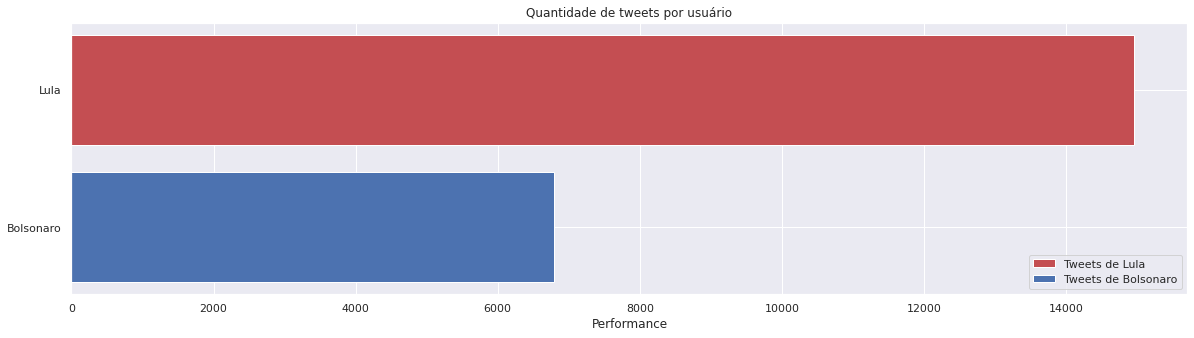

In [4]:
#@title Filtro de tempo para as análises e gráficos

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#@markdown Seleção opcional para período de análise 

datas_relevantes = pd.DataFrame(dict_datas_relevantes.items(), columns=["Data","Evento"])
datas_relevantes['Data'] = datas_relevantes['Data'].astype('datetime64[ns]')
data_inicial_analise = '2010-04-24'  #@param {type: "date"}
data_final_analise = '2011-01-08'  #@param {type: "date"}

#@markdown Os usuários abaixo terão seus tweets selecionados de acordo com as datas acima para análise

Lula = False #@param {type:"boolean"}
Bolsonaro = False #@param {type:"boolean"}

# data_inicial_analise = data_inicial_analise.join('00:00:00+00:00')
# data_final_analise = data_final_analise.join('00:00:00+00:00')

dic_datas_analise = {data_inicial_analise:"Data inicial da análise",
                     data_final_analise:"Data final da análise"}

datas_analise = pd.DataFrame(dic_datas_analise.items(), columns=datas_relevantes.columns)
datas_analise['Data'] = datas_analise['Data'].astype('datetime64[ns]')
# datas_analise['Data'] = pd.to_datetime(datas_analise['Data'])

dados_filtrados = Lula or Bolsonaro

if dados_filtrados:
  datas_relevantes = datas_relevantes.append(datas_analise).sort_values("Data")

col_data=[data_inicial_analise, data_final_analise]
datas = pd.DataFrame(col_data, columns=['data'])

datas = datas.data.astype('datetime64[ns]')
# datas = pd.to_datetime(datas.data)
if Bolsonaro:
  bolsonaro_filtrado = bolso_data.loc[bolso_data['created_at']>datas[0]]
  bolsonaro_filtrado = bolsonaro_filtrado.loc[bolsonaro_filtrado['created_at']<datas[1]]
else:
  bolsonaro_filtrado = bolso_data

if Lula :
  lula_filtrado = lula_data.loc[lula_data['created_at']>datas[0]]
  lula_filtrado = lula_filtrado.loc[lula_filtrado['created_at']<datas[1]]
else:
  lula_filtrado = lula_data


print("Selecionados ",lula_filtrado.shape[0], ' dos ',lula_data.shape[0]," tweets do lula")
print("Selecionados ",bolsonaro_filtrado.shape[0], ' dos ',bolso_data.shape[0]," tweets do Bolsonaro")


sns.set()
lula = ["Lula", 
        lula_filtrado.shape[0],
        lula_data.shape[0]-lula_filtrado.shape[0]]
bolso = ["Bolsonaro",
         bolsonaro_filtrado.shape[0],
         bolso_data.shape[0]-bolsonaro_filtrado.shape[0]]

dados = pd.DataFrame([lula,bolso], 
                    columns= ['usuario',
                              'tweets_selecionados',
                              'tweets_totais'])

# plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = dados.usuario
y_pos = np.arange(len(people))
performance = dados.tweets_selecionados
error = np.random.rand(len(people))
#barra do bolsonaro

lista_legenda = []

ax.barh(0, dados.tweets_selecionados.loc[dados.usuario=='Lula'],  align='center',color='#c44e52')
if Lula and dados.tweets_totais.loc[dados.usuario=='Lula'].values[0]>0:
  ax.barh(0, dados.tweets_totais.loc[dados.usuario=='Lula'],  align='center',color='#d16266',left = dados.tweets_selecionados.loc[dados.usuario=='Lula'])
  lista_legenda.append('Tweets selecionados de Lula')
  lista_legenda.append('Tweets não selecionados de Lula')
else:
  lista_legenda.append('Tweets de Lula')



ax.barh(1, dados.tweets_selecionados.loc[dados.usuario=='Bolsonaro'],  align='center',color='#4c72b0')

if Bolsonaro and dados.tweets_totais.loc[dados.usuario=='Bolsonaro'].values[0]>0:
  ax.barh(1, dados.tweets_totais.loc[dados.usuario=='Bolsonaro'],  align='center',color='#5d8cd9',left = dados.tweets_selecionados.loc[dados.usuario=='Bolsonaro'])
  lista_legenda.append('Tweets selecionados de Bolsonaro')
  lista_legenda.append('Tweets não selecionados de Bolsonaro')
else:
  lista_legenda.append('Tweets de Bolsonaro')




ax.set_yticks(y_pos)
ax.set_yticklabels(dados.usuario)
ax.invert_yaxis()  
ax.set_xlabel('Performance')
ax.set_title('Quantidade de tweets por usuário')
fig.set_size_inches(20,5)
plt.legend(lista_legenda)
plt.show()

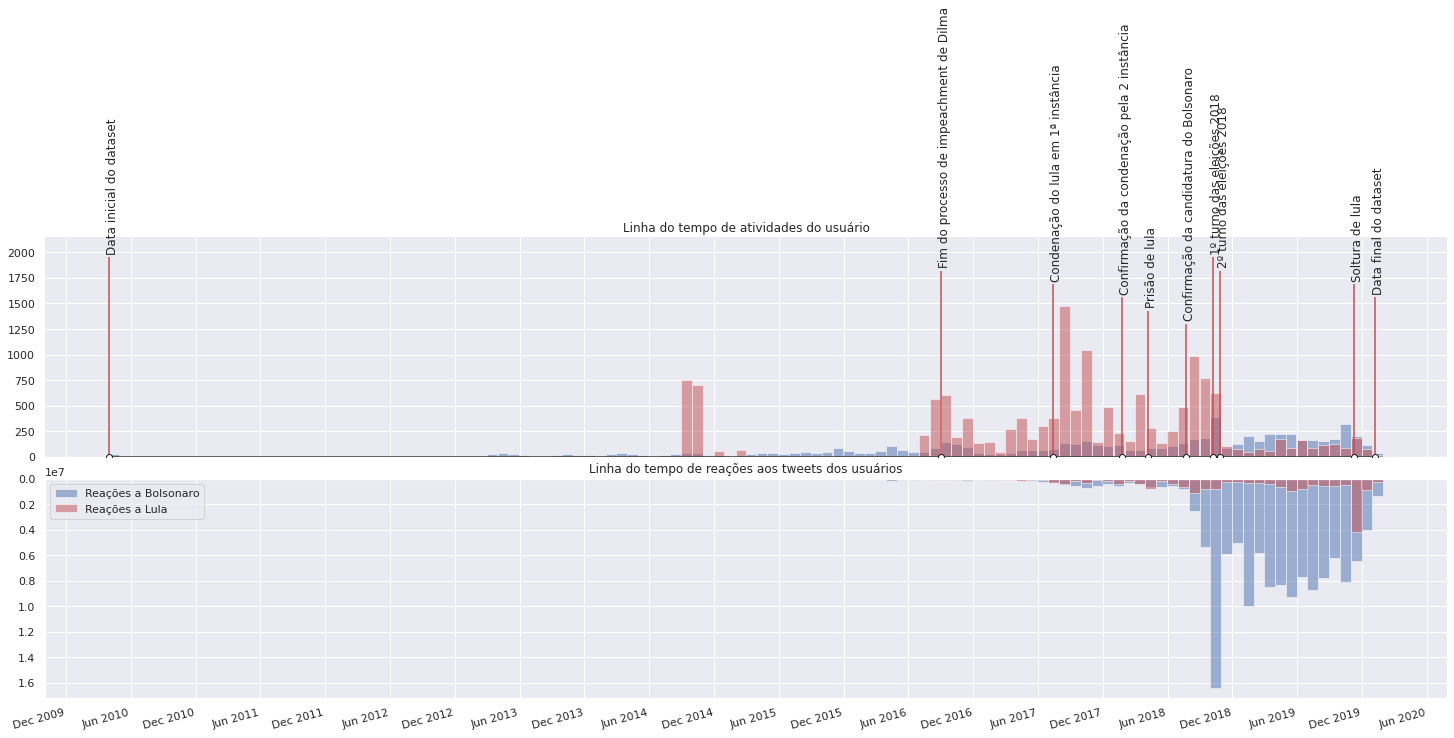

In [5]:
#@title Linha geral do tempo
#@markdown Visualização em gráfico da atividade dos dois políticos ao longo do período abrangido pelos datasets de entrada.

#@markdown Cada barra contém o acumulado mensal de tweets emitidos por cada usuário

#@markdown O gráfico contém anotações de alguns eventos políticos ocorridos para que se tenha uma ideia da atividade dos perfis em questão.

#@markdown Além dos eventos políticos o gráfico contém a anotação das datas escolhidas pelo usuário na célula acima.

escala_log_grafico_superior = False #@param {type:"boolean"}
escala_log_grafico_inferior = False #@param {type:"boolean"}
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
sns.set()
eventos = datas_relevantes['Evento']

dates = datas_relevantes['Data']

# Create figure and plot a stem plot with the date
fig, (ax,ax1) = plt.subplots(2,1,sharex=True)
ax.set(title="Linha do tempo de atividades do usuário")

levels = np.tile([1.5, 1.4, 1.3,1.2,1.1,1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]*1300



markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)



# format xaxis with 6 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

# remove y axis and spines
#ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

# weekly = lula_data['created_at'].resample('W').sum()

def ajuste_dataset_grafico(dataset):
  df = pd.DataFrame(dataset["created_at"].groupby([dataset["created_at"].dt.year,dataset["created_at"].dt.month]).count())
  df.columns = ['Count']
  df = df.reset_index(level=1)
  df.columns = ['Mes','Count']
  df = df.reset_index(level=0)
  df.columns = ['Ano', 'Mes','Count']
  df['datetime'] =pd.to_datetime( dict(year=df.Ano, month=df.Mes, day=15))
  df['datetime'] = df['datetime'].astype('datetime64[ns]')
  return df

b = ajuste_dataset_grafico(bolso_data)
l = ajuste_dataset_grafico(lula_data)
larguraBarra= 30
# ax.bar(x=b["datetime"],height=b['Count'],width=larguraBarra,color='b', alpha=0.5)
# ax.bar(x=l["datetime"],height=l['Count'],width=larguraBarra,color='r', alpha=0.5)

ax.bar(x=b["datetime"],height=b['Count'],width = larguraBarra, color='b', alpha=0.5)
ax.bar(x=l["datetime"],height=l['Count'],width = larguraBarra, color='r', alpha=0.5)

# levels = np.tile([6,5, 4,3,2,1],
#                  int(np.ceil(len(dates)/6)))[:len(dates)]



# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))
plt.legend(['Evento político','Bolsonaro','Lula'])
# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, eventos, vert):
    
    
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="left", rotation=90)

ax1.set(title="Linha do tempo de reações aos tweets dos usuários")


def ajuste_dataset_dataset_grafico_reacoes(dataset,colunas):

  col = colunas.copy()
  col.insert(0,'created_at')
  data = dataset[col].groupby([dataset["created_at"].dt.year,dataset["created_at"].dt.month]).sum()
  data = data.reset_index(level=1)
  col = colunas.copy()
  col.insert(0,'Mes')
  data.columns = col.copy()
  data = data.reset_index(level=0)
  col.insert(0,'Ano')
  data.columns = col.copy()
  data['datetime'] = pd.to_datetime( dict(year=data.Ano, month=data.Mes, day=15))
  data['datetime'] = data['datetime'].astype('datetime64[ns]')

  return data
colunas = ['retweet_count','favorite_count']
b = ajuste_dataset_dataset_grafico_reacoes(bolso_data,colunas)
l = ajuste_dataset_dataset_grafico_reacoes(lula_data,colunas)
# print(l.head())
larguraBarra= 31
ax1.bar(x=b["datetime"],height=b[colunas[0]]+b[colunas[1]],width = larguraBarra, color='b', alpha=0.5)
ax1.bar(x=l["datetime"],height=l[colunas[0]]+l[colunas[1]],width = larguraBarra, color='r', alpha=0.5)

plt.legend(['Reações a Bolsonaro','Reações a Lula'])

ax1.invert_yaxis()
ax1.set_yscale('log')
ax.set_yscale('log')
if escala_log_grafico_superior:
  ax.set_yscale('log')
else:
  ax.set_yscale('linear')
if escala_log_grafico_inferior :
  ax1.set_yscale('log')
else:
  ax1.set_yscale('linear')


# ax.set_xmargin(0.1)


ax1.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=15, ha="right")

# ax1.set_yscale()

ax.margins(y=0.1)
fig.set_size_inches(20,10)
fig.tight_layout(pad=0.0)
plt.show()

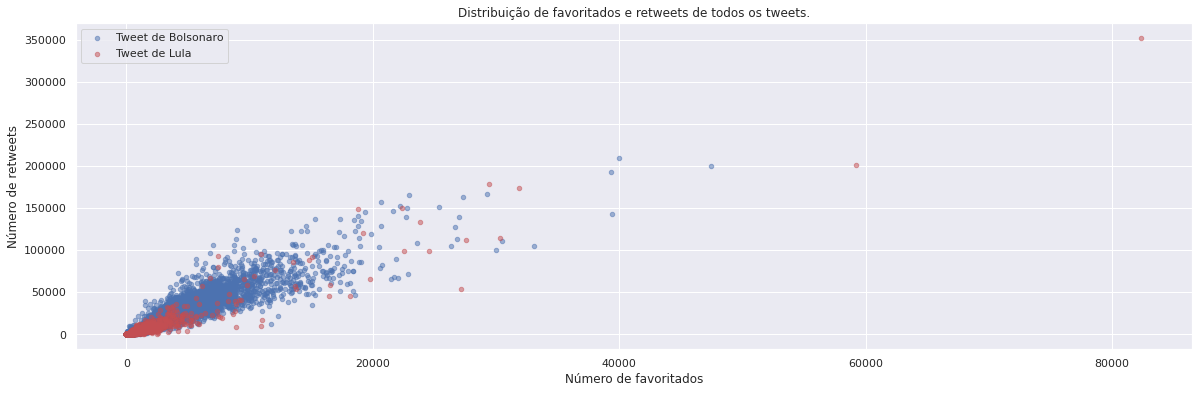

In [6]:
#@title Análise de dispersão das reações
#@markdown Visualização em gráfico de dispersão de quantidade de 'retweets' e quantidade de 'favoritado'. Os pontos azuis representam os tweets de Bolsonaro e os vermelhos representam os tweets de lula

#@markdown Por se tratar de uma variável com alguns outliers é recomendado que se utilize uma escala logaritmica para sua representação. Entretanto ao utilizar a escala logaritmica perde-se o senso da diferença entre as reações aos tweets dos dois usuários.
escala_log = False #@param {type:"boolean"}
#uso do estilo do seaborn
fig, ax = plt.subplots()
if escala_log:
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_xlim(xmin=10,xmax=100000000)
  ax.set_ylim(ymin=10,ymax=100000000)
else:
  ax.set_yscale('linear')
  ax.set_xscale('linear')
sns.set()

somaB = bolsonaro_filtrado['favorite_count'] + bolsonaro_filtrado['retweet_count']
somaL = lula_filtrado['favorite_count'] + lula_filtrado['retweet_count']


if somaB.mean() >= somaL.mean():  
  ax.scatter(y= bolsonaro_filtrado['favorite_count'], x= bolsonaro_filtrado['retweet_count'], color = 'b',s=20,alpha=0.5)
  ax.scatter(y= lula_filtrado['favorite_count'], x= lula_filtrado['retweet_count'],  color = 'r',s=20,alpha=0.5)
  plt.legend(['Tweet de Bolsonaro','Tweet de Lula'])
else:
  ax.scatter(y= lula_filtrado['favorite_count'], x= lula_filtrado['retweet_count'],  color = 'r',s=20,alpha=0.5)
  ax.scatter(y= bolsonaro_filtrado['favorite_count'], x= bolsonaro_filtrado['retweet_count'], color = 'b',s=20,alpha=0.5)
  plt.legend(['Tweet de Lula','Tweet de Bolsonaro'])
# Set the x-axis label
ax.set_xlabel("Número de favoritados")

# Set the y-axis label
ax.set_ylabel("Número de retweets")
if dados_filtrados:
  ax.set_title(''.join(["Distribuição de favoritados e retweets no período de ", data_inicial_analise," a ", data_final_analise,"."]))
else:
  ax.set_title(''.join(["Distribuição de favoritados e retweets de todos os tweets."]))
# ax.set_xlim(0,350000)

fig.set_size_inches(20,6)

plt.show()

2ª Etapa de limpeza de dados:

*   Foco no texto dos tweets
*   Retirada de caracteres especiais
*   Vetorização e contagem dos tokens



In [0]:
dict_usuario_texto = {"Lula":lula_data['full_text'].values,
                      "Bolsonaro":bolso_data['full_text'].values}
                      # ['\n'.join(bolso_data['full_text'].values)]

In [232]:
dict_usuario_texto["Lula"][0]

'Lula acaba de chegar ao @smabc de onde começará caminhada junto com @dilmabr #LulaeDilmanoABC'

In [228]:
import re
import string
from nltk.corpus import stopwords as sw
from string import punctuation
import nltk
from sklearn.feature_extraction.text import CountVectorizer

nltk.download("stopwords")  

dict_usuario_texto = {"Lula":lula_data['full_text'].values,
                      "Bolsonaro":bolso_data['full_text'].values)}
                      # ['\n'.join(bolso_data['full_text'].values)]

usuario_texto = pd.DataFrame(dict_usuario_texto.values(),columns=['textos_combinados'])
usuario_texto = usuario_texto.transpose()
usuario_texto.columns=['Lula','Bolsonaro']
usuario_texto = usuario_texto.transpose()

def limpeza_texto(tweets):
  
  for tweet in tweets:
    #deixa todo texto em minúsculo
    texto = tweet.lower()
    # print(texto)
    # texto = re.sub('[‘’“”…]', '', texto)
    
    #remove os links
    texto = re.sub(r'https?://\w+\.\w+\/\w+', '', texto, flags=re.MULTILINE)
    
    texto = re.sub('[‘’“”…]', '', texto)
    # texto = re.sub('^https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #remove texto entre colchetes
    texto = re.sub('\[.,!*?\]', '', texto)
    #remove pontuação
    texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
    #remove qualquer palavra que contenha um número, ou seja, uma palavra com erro de digitação
    texto = re.sub('\w*\d\w*', '', texto)
    #remove aspas e aspas duplas do texto
    
    #remove as quebras de linha
    texto = re.sub('\n', '', texto)
    #substitui tabulações por um espaço em branco
    texto = re.sub('\t', ' ', texto)
    #substitui um ou mais espaços em branco por um espaço
    texto= re.sub(r'\s+', ' ', texto, flags=re.I)
     
 
  return texto

for usuario in usuario_texto.index:
  usuario_texto.loc[usuario,:][0] = limpeza_texto(usuario_texto.loc[usuario,:][0])

def count_vectorizer(dataset):
  stopwords = sw.words('portuguese')
  
  cv = CountVectorizer(ngram_range=(1,1),stop_words=stopwords)
  lista_usuario = dataset.index
  lista_texto_vetorizado = []

  for usuario in dataset.index:
    data_cv = cv.fit_transform(dataset.loc[usuario,:])
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm = data_dtm.transpose()#.sort_values(0, ascending= False)
    data_dtm.columns = ['count']
    data_dtm = data_dtm.sort_values('count', ascending= False)
    # print(usuario)
    # print(data_dtm[:20])
    lista_texto_vetorizado.append(data_dtm)

  return dict(zip(lista_usuario, lista_texto_vetorizado))

def tfidf_vectorizer(dataset):




   return dict(zip(lista_usuario, lista_texto_vetorizado))

dict_count_vetorizer = count_vectorizer(usuario_texto)
# dict_tfidf = tfidf_vectorizer(usuario_texto)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer



def tfidf_vectorizer(dataset):




   return dict(zip(lista_usuario, lista_texto_vetorizado))


In [223]:
dict_texto_vetorizado.get("Lula")[:40]

,count
lula,4618
país,1467
brasil,1399
povo,1272
presidente,903
gente,902
pra,829
fazer,699
haddadfernando,659
agora,645


In [226]:
dict_texto_vetorizado.get("Bolsonaro")[:40]

,count
brasil,1202
bolsonaro,785
todos,541
governo,375
sobre,364
obrigado,334
abraço,298
pt,293
hoje,288
grande,285


3ª Etapa de limpeza de dados:

*   Retira arbitrária de palavras consideradas irrelevantes
*   Visualização das palavras



In [0]:
palavras_para_remocao = ['sobre',	'obrigado','ser', 'sobre','ricardo','stuckert','hoje','aqui','pode','vai','dia','pra']

In [225]:
# dict_texto_vetorizado['Lula'] = dict_texto_vetorizado['Lula'].drop(palavras_para_remocao,axis=0)
dict_texto_vetorizado['Lula'].head(20)

,count
lula,4618
país,1467
brasil,1399
povo,1272
presidente,903
gente,902
pra,829
fazer,699
haddadfernando,659
agora,645


In [202]:
dict_texto_vetorizado.repl get("Lula") = data.drop(["Y2001", "Y2002", "Y2003"], axis=0)
for palavra in dict_texto_vetorizado.get("Lula").index:

Index(['lula', 'país', 'brasil', 'povo', 'ser', 'presidente', 'gente', 'pra',
       'vai', 'fazer',
       ...
       'históriatenho', 'históriauma', 'históriavocê', 'históricasdez',
       'históricoessa', 'históricovídeo', 'hiv', 'hjninguém', 'ho', 'únicos'],
      dtype='object', length=22501)

In [0]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [0]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

for index, comedian in enumerate(data.columns):
    wc.generate(data_clean.transcript[comedian])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()